 c:\Users\leitg\anaconda3\Lib\site-packages\scipy\stats\_qmc.py:804: UserWarning:The balance properties of Sobol' points require n to be a power of 2.


(112, 3)


 c:\Users\leitg\anaconda3\Lib\site-packages\scipy\stats\_qmc.py:804: UserWarning:The balance properties of Sobol' points require n to be a power of 2.


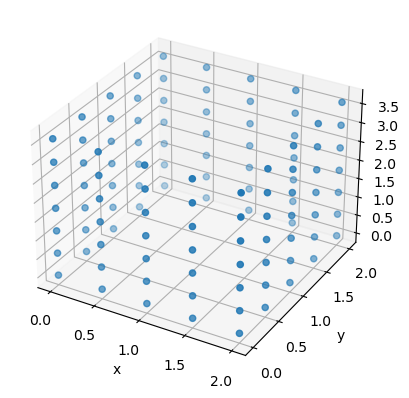

(212, 3)
(212, 1)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../../PI_GP_regressor')

from main_class import PhysicsInformedGP_regressor
from kernels.kernel_wave_3d import gram_Matrix,k_ff, k_fu, k_uf, k_uu

kernel_list = [gram_Matrix, k_uu, k_uf, k_fu, k_ff]
hyperparameters = ["l_space", "sigma", "l_t", "c"]
model = PhysicsInformedGP_regressor(kernel_list, params = hyperparameters,timedependence=True, Dimensions = 3)

n_training_points = 100

model.set_training_data("",n_training_points, noise = [1e-8,1e-8])
model.set_validation_data(1000)

# here we add extra boundary points to the training data to enforce the boundary conditions
boundary_points_space = np.array([[0,0],[2,2],[0,2],[2,0],[0,1],[1,0],
                                  [1,2],[2,1],[0.5,0],[0.5,2],[0,0.5],
                                  [2,0.5],[0,1.5],[2,1.5],[1.5,0],[1.5,2]])

t_points = np.arange(0,4,0.6)
boundary_points_all = []
for t in t_points:
    boundary_points_all.append(np.hstack((boundary_points_space,t*np.ones((len(boundary_points_space),1)))))
boundary_points_all = np.vstack(boundary_points_all)
print(boundary_points_all.shape)
model.X_u = np.vstack((model.X_u,boundary_points_all))
model.targets = np.vstack((model.u_train,np.zeros((len(boundary_points_all),1)),model.f_train))
model.u_train = np.vstack((model.u_train,np.zeros((len(boundary_points_all),1))))

#plot of the boundary points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(boundary_points_all[:,0],boundary_points_all[:,1],boundary_points_all[:,2])
#ax.scatter(model.X_u_test[:,0],model.X_u_test[:,1],model.X_u_test[:,2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('t')
plt.show()
print(model.X_u.shape)
print(model.u_train.shape)





In [4]:
model.jitter = 1e-6
def get_initial_values():
    """returns the initial values for the hyperparameters
    for the length scales we initialize them randomly as log(l) ~ U(-1.3,1)
    """
    rng = np.random.default_rng()
    theta_initial = np.zeros((4))
    theta_initial[0] = np.exp(rng.uniform(-1.3, 0.3, 1))  #lx
    #theta_initial[0] = rng.uniform(0, 1.2, 1)               #slx
    theta_initial[1] = rng.uniform(0, 1, 1)               #sigma_f
    theta_initial[2] = np.exp(rng.uniform(-4, -2, 1))  #lt
    #theta_initial[2] = rng.uniform(0, 1.2, 1)               #slt
    theta_initial[3] = rng.uniform(0, 2, 1)               #c
    return theta_initial
n_restarts = 500
n_threads = 6
opt_params_dict = {'theta_initial': get_initial_values,   #needed for all optimization methods
                    'bounds': ((1e-2, None), (1e-5, None), (1e-3, None),(1e-2, None)), #needed for TNC and L-BFGS-B
                    'gtol': 1e-7}
model.train("TNC",n_restarts, n_threads,opt_params_dict)

100%|██████████| 500/500 [03:47<00:00,  2.20it/s]


 message: Converged (|f_n-f_(n-1)| ~= 0)
 success: True
  status: 1
     fun: 93.6788558959961
       x: [ 5.707e-01  2.292e-01  4.817e-01  9.954e-01]
     nit: 15
     jac: [-1.101e-01  2.347e-02 -4.159e-01 -1.784e-01]
    nfev: 94


In [5]:
model.jitter = 1e-6
grid_number = 101
x = np.linspace(0,2,grid_number).reshape(-1,1)
y = np.linspace(0,2,grid_number).reshape(-1,1)
t = np.linspace(0,4,grid_number).reshape(-1,1)
gx, gy = np.meshgrid(x,y)

X_2d = np.c_[gx.ravel(), gy.ravel()]

time_points = np.linspace(0,4,81)

model.jitter = 1e-6
mean = []
var = []
for i in range(len(time_points)):
    X_3d = np.c_[gx.ravel(), gy.ravel(), time_points[i]*np.ones(len(gx.ravel()))]
    mean_i, var_i = model.predict_u(X_3d)
    mean.append(mean_i)
    var.append(var_i)
    
mean = np.array(mean)
mean = mean.reshape(len(time_points),grid_number,grid_number)
u_matrix = model.raw_data[2]
print(mean.shape)


model.jitter = 1e-6
mean2, var2 = model.predict_u(model.X_u_test)
rel_l2 = model.relative_l2_error
print("rel_l2_test_set:",rel_l2(mean2, model.u_test))
print("rel L2 error = ",rel_l2(mean[:,:,:],u_matrix[:,:,:].T))

(81, 101, 101)
rel_l2_test_set: 0.059028734
rel L2 error =  0.05919900028752127


(101, 101, 81)
(81, 101, 101)


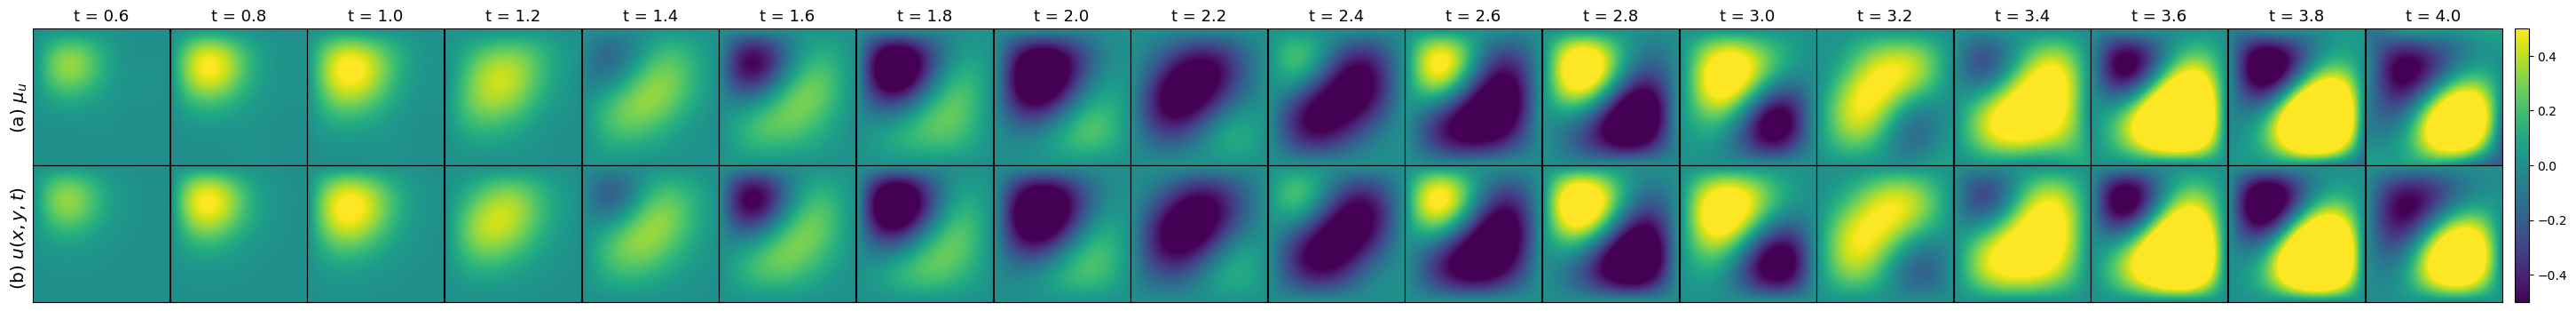

In [6]:

fig, ax = plt.subplots(2,18,figsize=(38,4),sharey=True,sharex=True)
fig.text(0.118, 0.6, r'(a) $\mu_u$', fontsize=14.5, rotation='vertical')
fig.text(0.118, 0.16, r'(b) $u(x,y,t)$', fontsize=14.5, rotation='vertical')
#no axis ticks
for a in ax.flatten():
    a.set_xticks([])
    a.set_yticks([])
ax = ax.flatten()


ax_1 = ax[:18]
ax_2 = ax[18:]
u_matrix = model.raw_data[2]
print(u_matrix.shape)
for i,t in zip(range(18),np.linspace(0, 2, len(u_matrix[0,0,:]))):
    ax_1[i].imshow(mean[i*4+12,:,:], 
    cmap='viridis',
    extent=[0,2,0,2],
    vmin = -0.5, 
    vmax = 0.5)

    ax_1[i].set_title('t = ' + str(np.round(time_points[i*4+12],4)), fontsize=13)
    im = ax_2[i].imshow(u_matrix[:,:,i*4+12].T, 
    cmap='viridis',
    extent=[0,2,0,2],
    vmin = -0.5, 
    vmax = 0.5)


fig.subplots_adjust(hspace=0.00, wspace=0.00)
fig.colorbar(im,ax=ax, orientation='vertical',fraction=0.05, pad=0.005)

plt.savefig('heatmap_grid_n100BV.png', dpi=300, bbox_inches='tight')
print(mean.shape)

(101, 101, 81)
(81, 101, 101)


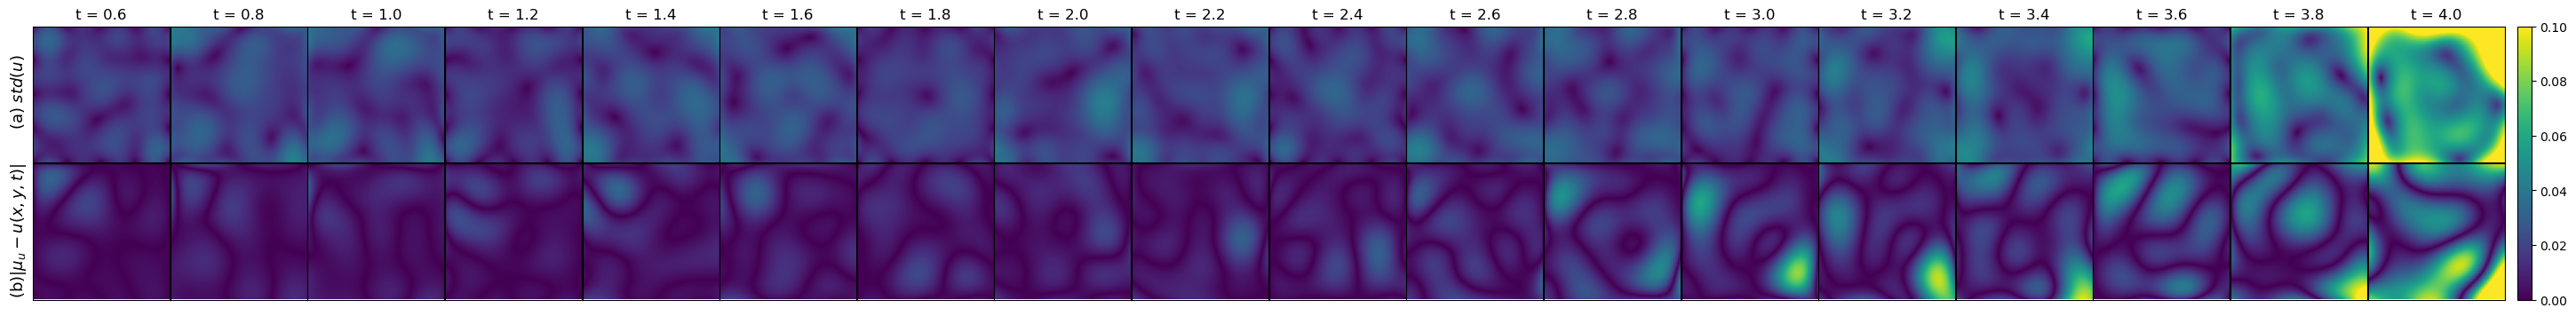

In [7]:
var = np.array(var)
var = var.reshape(len(time_points),grid_number,grid_number)
std = np.sqrt(var)

fig, ax = plt.subplots(2,18,figsize=(38,4),sharey=True,sharex=True)
fig.text(0.118, 0.6, r"(a) $std(u)$", fontsize=13, rotation='vertical')
fig.text(0.118, 0.13, r'(b)$|\mu_u - u(x,y,t)|$', fontsize=13, rotation='vertical')

#no axis ticks
for a in ax.flatten():
    a.set_xticks([])
    a.set_yticks([])
ax = ax.flatten()

ax_1 = ax[:18]
ax_2 = ax[18:]
u_matrix = model.raw_data[2]
print(u_matrix.shape)
for i,t in zip(range(18),np.linspace(0, 2, len(u_matrix[0,0,:]))):
    ax_1[i].imshow(std[i*4+12,:,:],
    cmap='viridis',
    extent=[0,2,0,2],
    vmin = -0., 
    vmax = 0.1)

    ax_1[i].set_title('t = ' + str(np.round(time_points[i*4+12],4)), fontsize=12)
    im = ax_2[i].imshow(np.abs(mean[i*4+12,:,:] - u_matrix[:,:,i*4+12].T),
    cmap='viridis',
    extent=[0,2,0,2],
    vmin = -0., 
    vmax = 0.1)

# Add titles to the first row and second row

#add space between rows


#fig.tight_layout()

fig.subplots_adjust(hspace=0.001, wspace=0.001)
fig.colorbar(im,ax=ax, orientation='vertical',fraction=0.05, pad=0.005)
plt.savefig('heatmap_grid_STD_n100BV.png', dpi=300, bbox_inches='tight')
print(mean.shape)

MovieWriter ffmpeg unavailable; using Pillow instead.


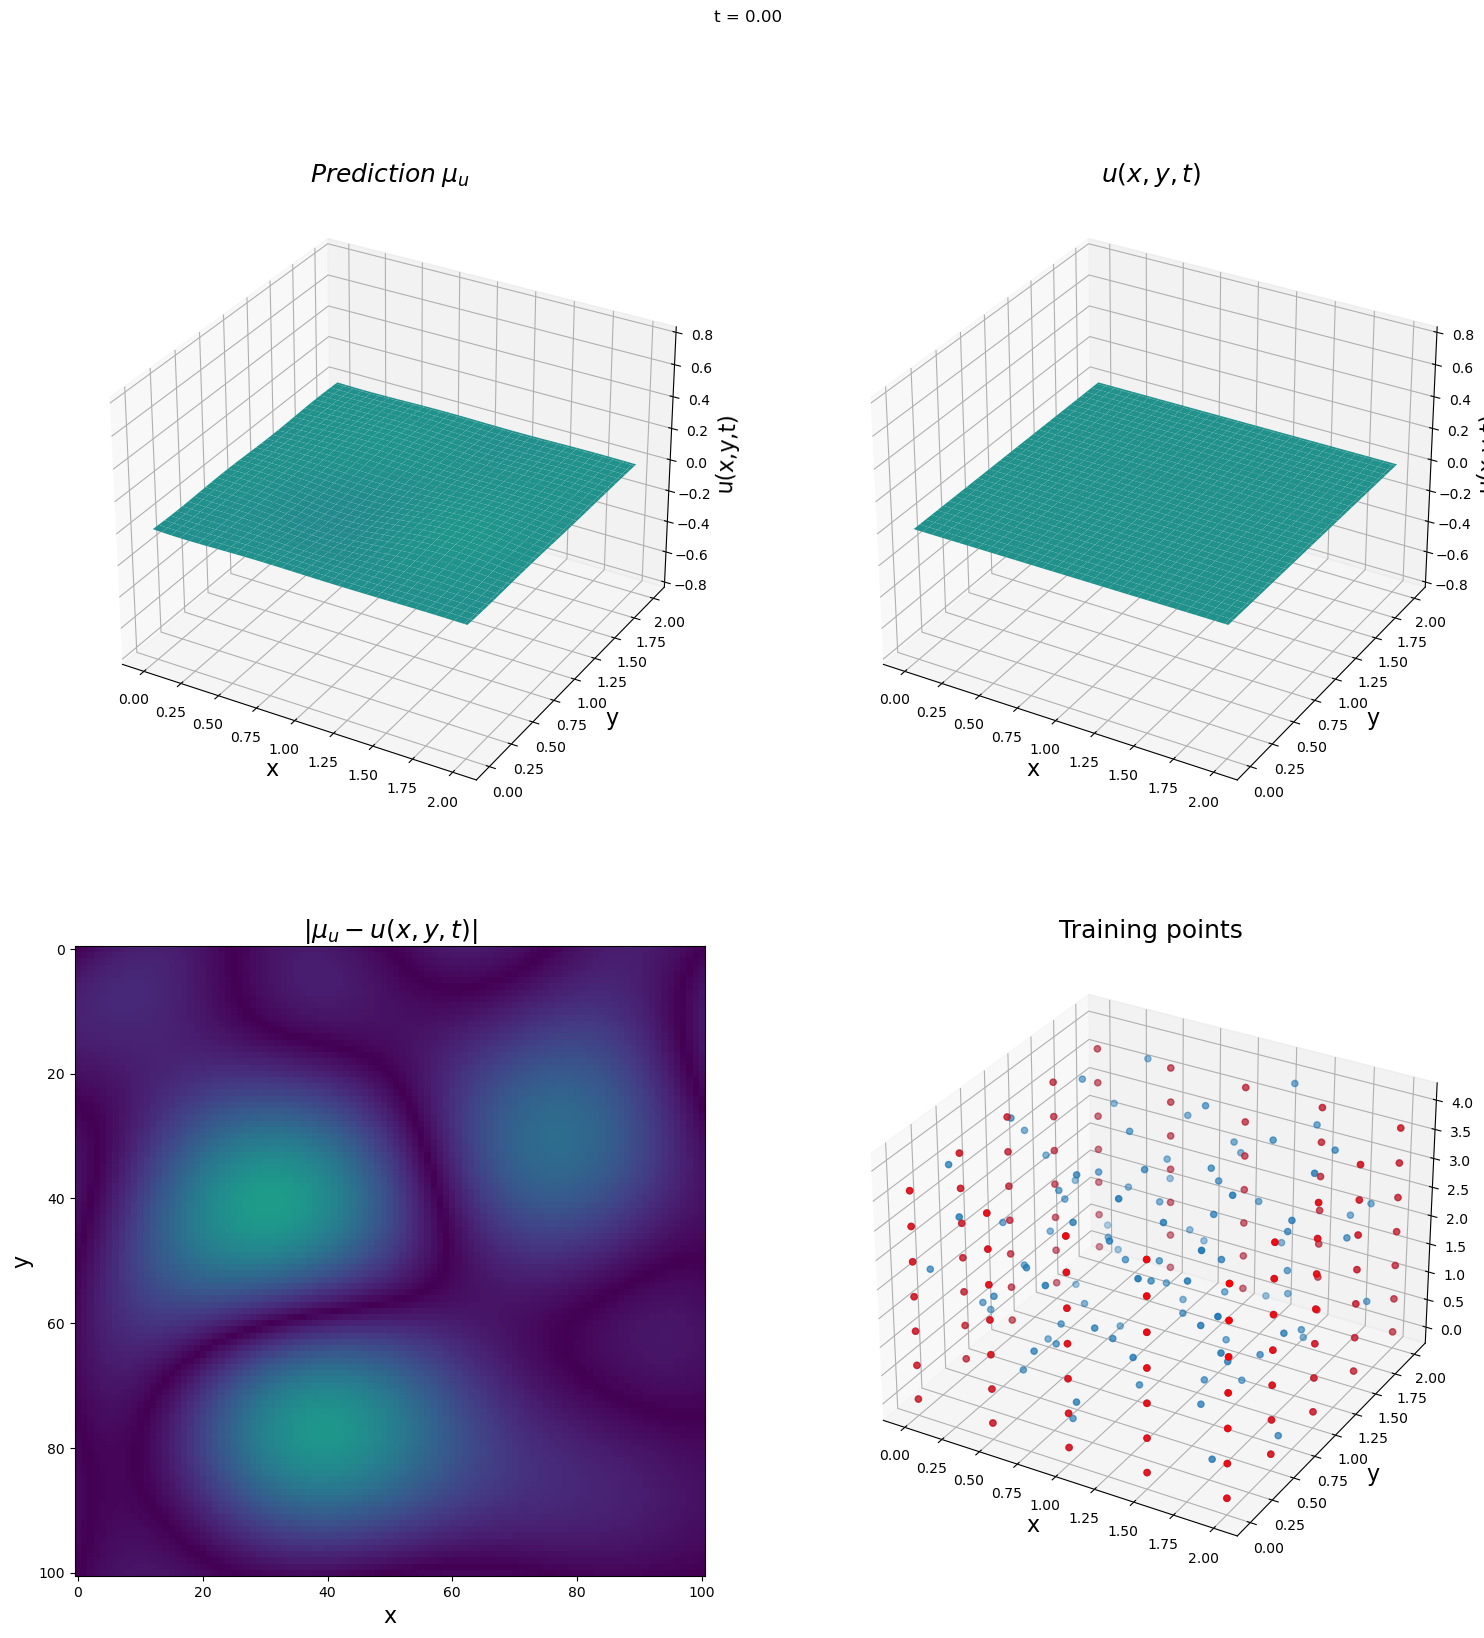

In [13]:
from matplotlib.animation import FuncAnimation
x,y,t = model.X_u[:,0], model.X_u[:,1], model.X_u[:,2]

fig = plt.figure(figsize=(18,18))
ax = [fig.add_subplot(2,2,1,projection="3d"), fig.add_subplot(2,2,2,projection="3d"), 
        fig.add_subplot(2,2,3), fig.add_subplot(2,2,4,projection="3d")]


#ax = ax.flatten()
def frame(i):
    
    fig.suptitle('t = ' + f"{time_points[i]:.2f}", fontsize=12)
    ax[0].clear()
    im = ax[0].plot_surface(gx,gy,mean[i,:,:].T, cmap='viridis',vmin = -0.5, vmax = 0.5)
    ax[0].set_title(r"$Prediction \; \mu_u$", fontsize=18)
    ax[0].set_zlim(-0.8,0.8)
    ax[0].set_zlabel('u(x,y,t)',fontsize=16)

    ax[1].clear()
    im = ax[1].plot_surface(gx,gy,u_matrix[:,:,i], cmap='viridis',vmin = -0.5, vmax = 0.5)
    ax[1].set_title(r"$u(x,y,t)$", fontsize=18)
    ax[1].set_zlim(-0.8,0.8)
    ax[1].set_zlabel('u(x,y,t)',fontsize=16)
    
    ax[2].clear()
    im_2 = ax[2].imshow(np.abs(mean[i,:,:] - u_matrix[:,:,i].T), cmap='viridis',vmin = 0, vmax = 0.05)
    
    ax[2].set_title(r"$|\mu_u - u(x,y,t)|$", fontsize=18)
    

    ax[3].clear()
    ax[3].scatter(x,y,t)
    ax[3].scatter(boundary_points_all[:,0],boundary_points_all[:,1],boundary_points_all[:,2],c='r')
    ax[3].set_title("Training points", fontsize=18)
    ax[3].set_zlabel('t',fontsize=16)
    for a in ax:
        a.set_xlabel('x',fontsize=16)
        a.set_ylabel('y',fontsize=16)
#plt.colorbar(im_2,ax=ax[2], orientation='vertical',fraction=0.05, pad=0.01)
ani = FuncAnimation(fig, frame, frames=len(time_points), repeat=False)

ani.save('movie files/3dplot_100_100bd.gif', writer='ffmpeg', fps=10,dpi = 200)
#plt.close()